Mounted at /content/gdrive
   YEAR  TIME_PRECISION EVENT_TYPE   LOCATION  LATITUDE  LONGITUDE  \
0  2001               1    Battles   Lohagara   23.1998    89.6644   
1  2001               1      Riots  Hathazari   22.5052    91.8134   
2  2001               1      Riots  Rangamati   22.6432    92.1919   
3  2001               1      Riots     Rajoir   23.1878    90.0322   
4  2001               1      Riots   Rajshahi   24.3740    88.6011   

   FATALITIES  WRapeIncident  WRapeDeath  BD_GDP  BD_GDP_GR  \
0           1            183         135     415      -0.73   
1           0            183         135     415      -0.73   
2           0            183         135     415      -0.73   
3           0            183         135     415      -0.73   
4           0            183         135     415      -0.73   

   ChildrenMortalityRate  AvgPopulationdensity  
0                   60.3           2307557.908  
1                   60.3           2307557.908  
2                   60.3  

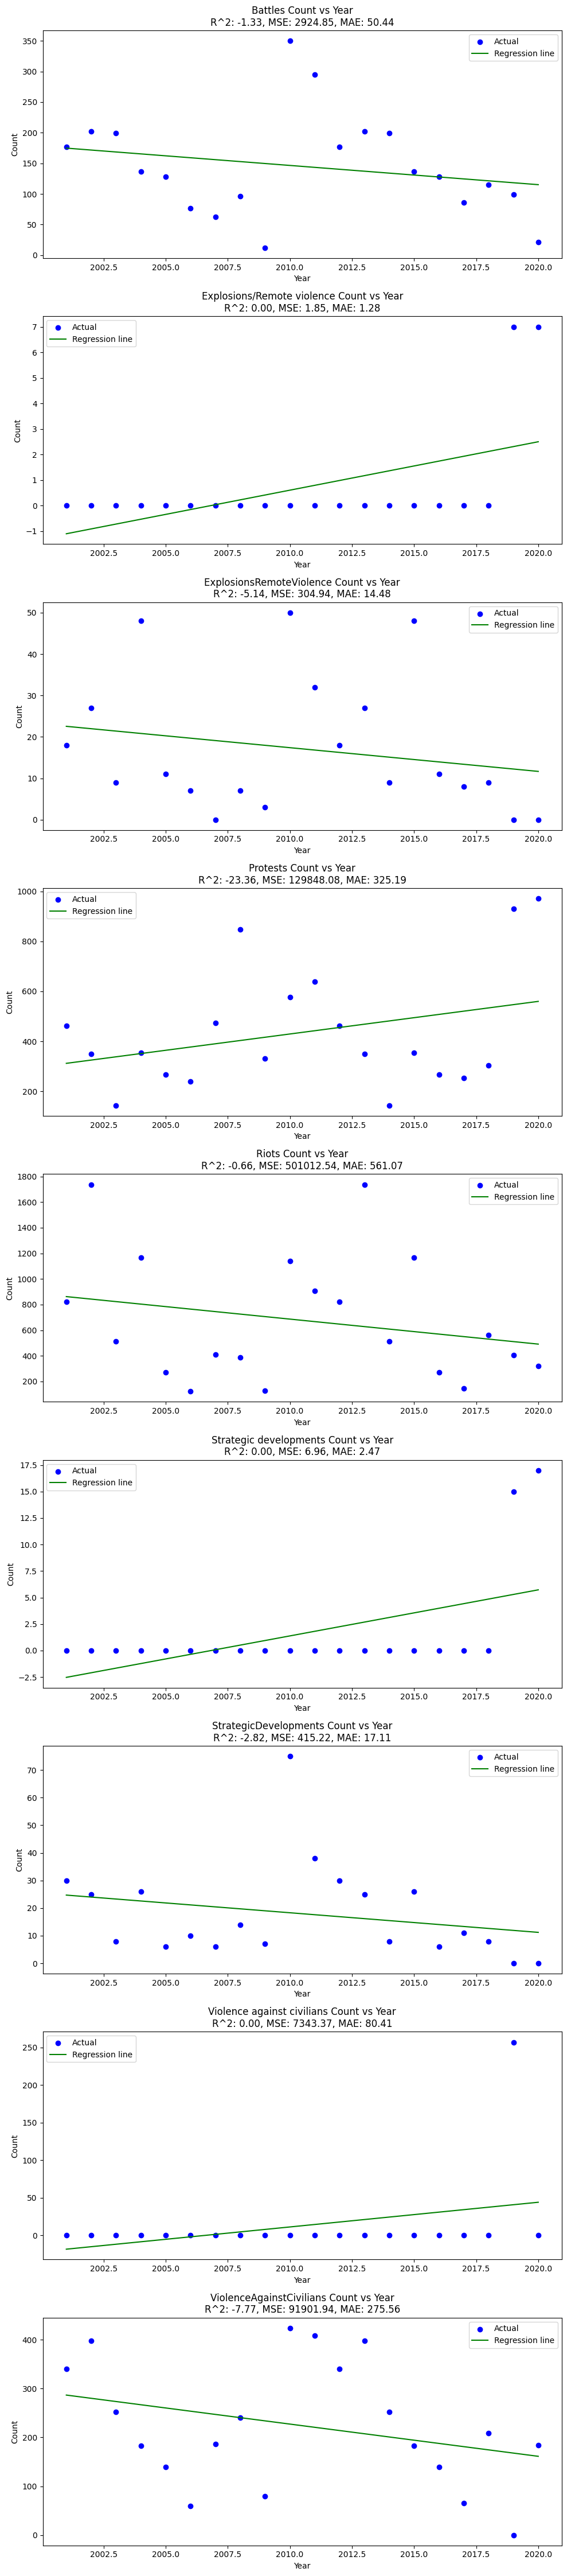

In [1]:
# Import necessary libraries
from google.colab import drive
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# Mount Google Drive
drive.mount("/content/gdrive")

# Load data from Excel file
data_path1 = '/content/gdrive/MyDrive/FYDP-2_DATA&Code/Copy of ACLED Data.xlsx'
df = pd.read_excel(data_path1)

# Display the first few rows of the dataframe to understand its structure
print(df.head())

# Define the feature columns and target column
feature_cols = ['YEAR', 'BD_GDP', 'BD_GDP_GR', 'AvgPopulationdensity']
target_col = 'EVENT_TYPE'

# Select relevant columns
df = df[['YEAR', 'BD_GDP', 'BD_GDP_GR', 'AvgPopulationdensity', 'EVENT_TYPE']]

# Group by YEAR and EVENT_TYPE and count occurrences
event_counts = df.groupby(['YEAR', 'EVENT_TYPE']).size().reset_index(name='count')

# Pivot the table to get years as rows and event types as columns
event_counts_pivot = event_counts.pivot(index='YEAR', columns='EVENT_TYPE', values='count').fillna(0)

# Reset index to make YEAR a column again
event_counts_pivot = event_counts_pivot.reset_index()

# Merge with original features based on YEAR
df_features = df[['YEAR', 'BD_GDP', 'BD_GDP_GR', 'AvgPopulationdensity']].drop_duplicates()
merged_data = pd.merge(df_features, event_counts_pivot, on='YEAR')

# Display the merged data
print(merged_data.head())

# Define features (X) and target (y)
X = merged_data[['YEAR', 'BD_GDP', 'BD_GDP_GR', 'AvgPopulationdensity']]
y = merged_data.drop(columns=['YEAR', 'BD_GDP', 'BD_GDP_GR', 'AvgPopulationdensity'])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Predict the target values for the test set
y_pred = model.predict(X_test)

# Calculate and print metrics for each event type
event_types = y.columns
metrics = {}

for i, event in enumerate(event_types):
    r2 = r2_score(y_test[event], y_pred[:, i])
    mse = mean_squared_error(y_test[event], y_pred[:, i])
    mae = mean_absolute_error(y_test[event], y_pred[:, i])
    metrics[event] = {'R^2': r2, 'MSE': mse, 'MAE': mae}

# Print all metrics at once
for event, metric in metrics.items():
    print(f"Metrics for {event}:")
    print(f"  R^2: {metric['R^2']:.2f}")
    print(f"  MSE: {metric['MSE']:.2f}")
    print(f"  MAE: {metric['MAE']:.2f}")
    print()

# Function to plot scatter plot and regression line for YEAR vs EVENT_TYPE counts
def plot_year_vs_event_type(merged_data, event_types, model):
    X_year = merged_data[['YEAR']]

    # Initialize a figure for plotting
    fig, axes = plt.subplots(len(event_types), 1, figsize=(10, 5*len(event_types)))

    # Perform regression and plot for each event type
    for i, event in enumerate(event_types):
        y_event = merged_data[[event]]

        # Initialize and train the linear regression model
        model.fit(X_year, y_event)

        # Predict the target values
        y_pred_event = model.predict(X_year)

        # Plot actual data points
        axes[i].scatter(X_year, y_event, color='blue', label='Actual')

        # Plot the regression line
        axes[i].plot(X_year, y_pred_event, color='green', label='Regression line')

        # Set plot labels and title
        axes[i].set_xlabel('Year')
        axes[i].set_ylabel('Count')
        axes[i].set_title(f'{event} Count vs Year\nR^2: {metrics[event]["R^2"]:.2f}, MSE: {metrics[event]["MSE"]:.2f}, MAE: {metrics[event]["MAE"]:.2f}')
        axes[i].legend()

    plt.tight_layout()
    plt.show()

# Plotting YEAR vs EVENT_TYPE counts
plot_year_vs_event_type(merged_data, y.columns, model)
